In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import io
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import timedelta, datetime

from PIL import Image
from time import sleep

#!conda install -c conda-forge geocoder --yes    # uncomment line if geocoder needs to be installed
import geocoder
#!conda install -c conda-forge backoff
import backoff

from geopy.distance import geodesic
import folium


# General Notes  

This analysis was completed over several days.  To minimize the re-running all the previous steps, incremental versions of the data was saved.  Throughout the notebook you'll see places to load the "Clean & Enriched" data frame from storage.  Similarly, you'll see many statements commented out as not all cleansing steps were required on a given run of analysis. 

If something doesn't quite make sense, it is most likely the result of loading the DataFrame from storage and skipping unecessary steps.

# Data Collection


### Local High School On-Line Schedule

**Notes**  
  - The 2019-2020 schedule is not online yet, so using last years schedule to test & build the  model.
  - The school selected is an Independent, College Prepratory school, near to where I live.


### Prep the Sporting Event Location Data
1.  Web-Scrape the Schedule for Location Names  
1.  Enrich Location Names with Geocode Data  
1.  Generate high-level travel route data based on location  
1.  Store Intermediary DataFrame so don't need to continue to web-scrape and call API's  

 
 **NOTES** 
 - In Future runs, jump down to where DataFrame is loaded from CSV.  


In [3]:
schedule_url = 'https://www.cushing.org/team-detail?fromId=204845&Team=87969&SeasonLabel=2018+-+2019'
_headers = {
    'User-Agent': 'My User Agent 1.0'
}
r = requests.get(schedule_url, headers=_headers )
# print (r.text)

In [4]:
html_soup = BeautifulSoup(r.text, 'html.parser')
det_containers = html_soup.find_all('div', class_='game')
web_event_data = [[s for s in containers.stripped_strings] for containers in det_containers]

In [5]:
# Loop through web-data, make a dictionary for each game listed on the website
sporting_event_list = []
for game in web_event_data:
    idx = 0
    sporting_event = {}
    sporting_event['date'] = game[idx]
#    date_list.append(sporting_event['date'])  # create separate list of values to c
    idx += 1
    sporting_event['time'] = game[idx]
    idx += 1
    sporting_event['home_away'] = game[idx]
    idx += 1
    if game[idx] == 'Scrimmage':
        idx += 1
    if game[idx] == 'vs.':
        idx += 1 # skip 'vs.'
    sporting_event['opponent_school'] = game[idx]
    idx += 1
    sporting_event_list.append(sporting_event)

From that list of games, make a pandas DataFram

In [6]:
games_df = pd.DataFrame(sporting_event_list)
games_df.head()

,date,home_away,opponent_school,time
0,"Wednesday, 11/28/2018",Away,Middlesex School,5:00 PM
1,"Friday, 11/30/2018",Away,Dana Hall School,5:30 PM
2,"Saturday, 12/1/2018",Home,Buckingham Browne & Nichols,3:00 PM
3,"Wednesday, 12/5/2018",Away,Holderness School,3:30 PM
4,"Saturday, 12/8/2018",Away,Vermont Academy,4:00 PM


### Starting Geocoding based on school name   


**NOTE:** 
- It is common to play the same opponent year after year.
- As a result, the analysis will be completed for all opponents, but final list of analysis, will only include 'travel sites' (i.e. "Away" games)


First step is to set the **HOME** Location, so there is a starting point when calculating distances.


In [7]:
home_location_name = 'Cushing Academy'
g = geocoder.osm(home_location_name)
if not g.ok:
    print ('GeoCode Failed')
    
home_location = {'quality': g.json['quality'], 'address': g.json['address'] , 'state': g.json['state'], 'lat': g.json['lat'], 'lng': g.json['lng']}
print(home_location)

{'quality': 'school', 'address': 'Cushing Academy, 39, School Street, Ashburnham, Worcester County, Massachusetts, 01430, United States of America', 'state': 'Massachusetts', 'lat': 42.63286695, 'lng': -71.9135057096491}


---  
### Geocoding helper functions  

Define functions to make data processing easier

- Function `get_geo_info`  
  Looks up the latitude and longitude for a school based on school name and returns a Pandas Series, so it's easier to build build a DataFrame while looping through list of school names.   This function also tries multiple geocoding services to find latitude and longitude.  It first starts with Open Street Maps Nominatim, if no results are found, it tries the free version of the ArcGIS service.
  
<br>
  
- Function `clean_row_geo_info`  
  A helper function to correct coordinates in the event location list.  Pass in the index of the row to correct in teh DataFrame, along with the preferred search terms, and it will correct the DataFrame.  
  
<br>

- Function `get_route_data`  
  A helper function to get the route information between two sets of coordinates.  The service is basically a "Demo" service, so fold int logic to handle multiple retries, and smart backoff logic to increase liklihood the server will be able able to process the routing requests.   
  
  Using Project OSRM Routing Service

  `http://router.project-osrm.org/route/v1/driving/-71.91356999999994,42.63187000000005;-71.6747789477679,43.76177855`  

  
<br> 

- Function `convert_meters_to_miles`  
  The routing service returns driving distance between two coordinate points in meters.  This converts meters to miles.  
  
  Meters to Miles conversion = meters * 0.00062137

  
<br>  

- Function `convert_seconds_to_duration_str`  
  The routing service returns driving duration between two coordinate points in seconds.  This converts seconds into an `hh:mm` string to represent the duration.  
  
  

In [11]:
## Define Function to look-up Geocode by school name
def get_geo_info(_name):
    g = geocoder.osm(_name)
    if not g.ok:
        # Try another Geocoder
        print ('trying ArcGIS for {}'.format(_name))
        g = geocoder.arcgis(_name)
        if not g.ok:
            print ('Had a problem with {}'.format(_name))
            return pd.Series({'quality': 'error', 'address': 'error', 'state': 'error', 'lat': 0, 'lng': 0})
        # arcgis does not have as many fields     
        return pd.Series({'quality': g.json['quality'], 'address': g.json['address'] , 'state': 'n/a', 'lat': g.json['lat'], 'lng': g.json['lng']})

    
    return pd.Series({'quality': g.json['quality'], 'address': g.json['address'] , 'state': g.json['state'], 'lat': g.json['lat'], 'lng': g.json['lng']})

In [79]:
## Clean-Up Function ... some Geocodes matched the wrong school
def clean_row_geo_info(_dataframe, _df_index, _better_search_name):
    g = geocoder.osm(_better_search_name)
    #print ('old value', _dataframe.iloc[_df_index])
    geo_data = None
    if not g.ok:
        # Try another Geocoder
        print ('trying ArcGIS for {}'.format(_better_search_name))
        g = geocoder.arcgis(_better_search_name)
        if not g.ok:
            print ('Had a problem with {}'.format(_better_search_name))
            return 
        # arcgis does not have as many fields     
        geo_data = {'quality': g.json['quality'], 'address': g.json['address'] , 'state': 'n/a', 'lat': g.json['lat'], 'lng': g.json['lng']}
    else:
        geo_data = {'quality': g.json['quality'], 'address': g.json['address'] , 'state': g.json['state'], 'lat': g.json['lat'], 'lng': g.json['lng']}
    
    _dataframe.at[_df_index, 'quality'] = geo_data['quality']
    _dataframe.at[_df_index, 'address'] = geo_data['address']
    _dataframe.at[_df_index, 'state'] = geo_data['state']
    _dataframe.at[_df_index, 'lat'] = geo_data['lat']
    _dataframe.at[_df_index, 'lng'] = geo_data['lng']   
    #print ('new value', _dataframe.iloc[_df_index])

    
    return
    

In [120]:
@backoff.on_exception(backoff.expo,
                      requests.exceptions.RequestException,
                      max_tries=8,
                     jitter=backoff.full_jitter)    
def get_route_data(_row):
    url = 'http://router.project-osrm.org/route/v1/driving/{},{};{},{}'.format(home_location['lng'], home_location['lat'],
                                                                              _row['lng'], _row['lat'])
    
    r = requests.get(url)
    r.raise_for_status()  # Ugly, but blowup if web-request doesn't work
    r_data = r.json()
#    print (r.text)
    print ( _row['opponent_school'], r_data['code'])  # make sure this is 'Ok'
    print (datetime.utcnow())  # Just checking backoff :) 
    if len(r_data['routes']) > 0:
        r_data = r_data['routes'][0] # Just grab first available route ...
    else:
        print (r_data['code'], _row['opponent_school'])
        return pd.Series({'distance_meters': 0, 'duration_seconds': 0})
    
    return pd.Series({'distance_meters': r_data['distance'], 'duration_seconds': r_data['duration']})
    

In [10]:
def convert_meters_to_miles(_meters):
    return _meters * 0.00062137

def convert_seconds_to_duration_str(_seconds):
    return str(timedelta(seconds=_seconds))[0:4]  # only show HH:MM  in e 

### Actually do the geocoding work 

Using the helper functions above, add data from geocoding services to the list of sporting events locations (i.e. the games)

In [12]:
# Get Lat & Long for school names
games_df[["quality", "address", "state", "lat", "lng"]] = games_df['opponent_school'].apply(get_geo_info)

trying ArcGIS for Dexter Southfield School


### Data Cleansing 

Iterative run & re-run the following few cells, to clean-up the data that needs it, due to incorrect GEOCode Searches.  The first cell is to verify the results, the cell after is actually the clean-up functions.

Commenting out the statements after they've cleansed the data, but keeping them in the cell for future reference.  (But after you
you fixed the data, don't need to keep fixing it) 


In [135]:
#  Check the States, make sure all the Geocode results look OK
games_df['state'].value_counts()

# Interrogate unexpected  records
#games_df.loc[games_df['state'] == 'Pennsylvania']
#games_df.loc[games_df['state'] == 'n/a']
#games_df.loc[games_df['state'] == 'North Carolina']



Massachusetts    14
New Hampshire     5
Connecticut       2
Rhode Island      1
Vermont           1
Name: state, dtype: int64

In [132]:
# Clean-Up Records
#clean_row_geo_info(games_df, 12, "Brooks School, North Andover, MA")
#clean_row_geo_info(games_df, 14, "St. George's School, RI, US")
#clean_row_geo_info(games_df, 18, "Lawrence Academy, MA, US")
#clean_row_geo_info(games_df, 21, "Dexter Southfield, Brookline, MA, 02445, US")
#clean_row_geo_info(games_df, 22, "St. Paul's School, NH, US")
# games_df.at[21, 'state'] = 'Massachusetts'   # ArcGIS doesn't provide state, but I know it

### Just as a nice to have, add route data

Fetch driving routes, based on coordinates, to get distance & duration

And then transform from meters & seconds to miles & string of the form "hh:mm"

In [136]:
# get Driving Distance & Duration from "home school" (Cushing Academy) to each school
games_df[['distance_meters', 'duration_seconds']] = games_df.apply(get_route_data, axis=1)
print ('route data loaded')
games_df.head()

Middlesex School Ok
2019-10-29 02:18:11.137362
Middlesex School Ok
2019-10-29 02:18:11.201199
Dana Hall School Ok
2019-10-29 02:18:11.337350
Buckingham Browne & Nichols Ok
2019-10-29 02:18:11.634155
Holderness School Ok
2019-10-29 02:18:11.735303
Vermont Academy Ok
2019-10-29 02:18:11.839715
Miss Porter's school Ok
2019-10-29 02:18:11.983652
Phillips Exeter Academy Ok
2019-10-29 02:18:12.088022
Williston Northampton School Ok
2019-10-29 02:18:12.182747
Winchendon School Ok
2019-10-29 02:18:12.302089
Pomfret School Ok
2019-10-29 02:18:12.377947
St. Mark's School Ok
2019-10-29 02:18:12.481404
Governor's Academy Ok
2019-10-29 02:18:12.601893
Brooks School Ok
2019-10-29 02:18:12.715567
Wilbraham & Monson Academy Ok
2019-10-29 02:18:12.809741
St. George's School Ok
2019-10-29 02:18:12.930576
Brewster Academy Ok
2019-10-29 02:18:13.030945
Kimball Union Academy Ok
2019-10-29 02:18:13.120090
Northfield Mt. Hermon School Ok
2019-10-29 02:18:13.306882
Lawrence Academy Ok
2019-10-29 02:18:13.4157

,date,home_away,opponent_school,time,quality,address,state,lat,lng,distance_meters,duration_seconds,distance_miles,duration_str
0,"Wednesday, 11/28/2018",Away,Middlesex School,5:00 PM,school,"Middlesex School, 1400, Lowell Road, Concord, ...",Massachusetts,42.499832,-71.368431,62722.6,3051.1,38.973942,0:50
1,"Friday, 11/30/2018",Away,Dana Hall School,5:30 PM,school,"Dana Hall School, 45, Dana Road, Wellesley, No...",Massachusetts,42.290910,-71.288481,89181.5,4490.4,55.414709,1:14
2,"Saturday, 12/1/2018",Home,Buckingham Browne & Nichols,3:00 PM,school,Buckingham Browne & Nichols School (Middle Sch...,Massachusetts,42.380804,-71.131203,82363.5,4125.8,51.178208,1:08
3,"Wednesday, 12/5/2018",Away,Holderness School,3:30 PM,school,"Holderness School, Chapel Lane, Holderness, Gr...",New Hampshire,43.761779,-71.674779,167290.4,7161.0,103.949236,1:59
4,"Saturday, 12/8/2018",Away,Vermont Academy,4:00 PM,school,"Vermont Academy, Shepard Lane, Saxtons River, ...",Vermont,43.144794,-72.509698,90163.1,5072.3,56.024645,1:24


In [3]:
# Convert the Routing information into differt units
#games_df['distance_miles'] = games_df['distance_meters'].apply(convert_meters_to_miles)
#games_df['duration_str'] = games_df['duration_seconds'].apply(convert_seconds_to_duration_str)


In [71]:
games_df.describe()

NameError: name 'games_df' is not defined

In [157]:
max_distance = games_df['duration_seconds'].idxmax()
print ('The Median Travel Distance is: %.1f miles' % games_df['distance_miles'].median())
print ('The Median Travel Duration is:', convert_seconds_to_duration_str(5013.800000))
print ('The game at {} is the farthest drive, at %.1f miles'.format(games_df.iloc[max_distance]['opponent_school']) % games_df.iloc[max_distance]['distance_miles'])


NameError: name 'games_df' is not defined

##  Save the Games DataFrame

Now that the Games (sporting event location) DataFrame is cleansed & enriched, save it to a CSV, so you can jump right here and just reload it.
(before getting started on the Foursquare work

In [7]:
# Save games_df form project files

# There are some additional enrichments below, made to the games_loc_df, and I want to persist the refined enrichmetns between runs.
# --> So choose one of the DataFrames to store... 

#project.save_data("game_location_data.csv", games_df.to_csv(index=False))

project.save_data("game_location_data.csv", games_loc_df.to_csv(index=False), overwrite=True)



{'file_name': 'game_location_data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '66441db3-de56-4445-88d9-a177398bbdef'}

---

## Load the Location DataFrame from CSV to get started with Foursquare API analysis

Picking up with analysis, and starting with clean event location data.


The next few cells loads the Games Locations DataFrame and explores and summarizes the data

In [8]:
games_loc_df = pd.read_csv(project.get_file('game_location_data.csv'))
games_loc_df.head()

,date,home_away,opponent_school,time,quality,address,state,lat,lng,distance_meters,duration_seconds,distance_miles,duration_str,Nearby Venue Count,duration_minutes
0,"Wednesday, 11/28/2018",Away,Middlesex School,5:00 PM,school,"Middlesex School, 1400, Lowell Road, Concord, ...",Massachusetts,42.499832,-71.368431,62722.6,3051.1,38.973942,0:50,16,50.851667
1,"Friday, 11/30/2018",Away,Dana Hall School,5:30 PM,school,"Dana Hall School, 45, Dana Road, Wellesley, No...",Massachusetts,42.290910,-71.288481,89181.5,4490.4,55.414709,1:14,87,74.840000
2,"Saturday, 12/1/2018",Home,Buckingham Browne & Nichols,3:00 PM,school,Buckingham Browne & Nichols School (Middle Sch...,Massachusetts,42.380804,-71.131203,82363.5,4125.8,51.178208,1:08,239,68.763333
3,"Wednesday, 12/5/2018",Away,Holderness School,3:30 PM,school,"Holderness School, Chapel Lane, Holderness, Gr...",New Hampshire,43.761779,-71.674779,167290.4,7161.0,103.949236,1:59,41,119.350000
4,"Saturday, 12/8/2018",Away,Vermont Academy,4:00 PM,school,"Vermont Academy, Shepard Lane, Saxtons River, ...",Vermont,43.144794,-72.509698,90163.1,5072.3,56.024645,1:24,3,84.538333


In [36]:
games_loc_df.shape

(23, 15)

In [5]:
games_loc_df.groupby(['home_away']).sum()


,Unnamed: 0,Unnamed: 0.1,lat,lng,distance_meters,duration_seconds,distance_miles,Nearby Venue Count,duration_minutes
home_away,,,,,,,,,
Away,134,134,554.005476,-931.674694,1404413.7,68683.9,872.660541,822,1144.731667
Home,119,119,425.923545,-719.009241,943099.7,45297.7,586.013861,568,754.961667


In [159]:
games_loc_df.groupby(['home_away']).agg({'distance_miles': ['sum', 'mean', 'median'],
                                        'duration_minutes': ['sum', 'mean', 'median']})

distance_miles                       duration_minutes             \
                     sum       mean     median              sum       mean   
home_away                                                                    
Away          872.660541  67.127734  61.506807      1144.731667  88.056282   
Home          586.013861  58.601386  58.546569       754.961667  75.496167   

                      
              median  
home_away             
Away       84.538333  
Home       76.582500

In [86]:
print ('Total roundtrip miles traveled for 13 away games was {:,.1f} miles with an estimated duration of {}'.format(872.660541 * 2., str(timedelta(seconds=68683.9 * 2.))[:-10]))
print ('The average one-way trip distance was {:,.1f} miles for the {} Away games'.format(games_loc_df.loc[games_loc_df['home_away'] == 'Away']['distance_miles'].mean(),
                                                                                  games_loc_df.loc[games_loc_df['home_away'] == 'Away']['distance_miles'].count()) )

Total roundtrip miles traveled for 13 away games was 1,745.3 miles with an estimated duration of 1 day, 14:09
The average one-way trip distance was 67.1 miles for the 13 Away games


---  
---  
# Venue Related Data Collection


### Now on to Foursquare / Venue Data Collection


-  Limit Foursquare search to 100 venues per sporting event location  
-  The Search Radius is 2.5 miles around any event location



### Some Foursquare Helper Functions  

- Function `getNearbyVenues`  
  Use the Foursquare `Explore` API endpoint to fetch the top 100 most recommended venue with a radius of a given location.  
<br>  

- Function `get_venue_rating`  
  Use the Foursquare API to get additional information such as `rating`.  **Note** this is a _premium_ call.  As such Foursquare limits the amount of venue information you can access free-of-charge.  As a result, rating data is only a _nice to have_, and not every venue in the analysis has rating data.    
  
  This function tries to be economical with API access, so if it detects an existing rating, it will skip that record and move on to the next, in an attempt to get maximum number of venues with venue rating information.  
  
<br>  

- Function `get_parent_category`  
  For a given category return the top level parent for that category.  Example `Multiplex` is a child of `Movie Theater` which is a child of `Arts & Entertainment`  In this case, you pass in the category id for `Multiplex` and you are returned `Arts & Entertainment`  
<br>  

  
- Function `traverse_children`  
  Categories in Foursquare are stored in a tree structure.  This function traverses the tree and builds a 1:1 mapping of all categories to their top-level parent.  The results of this traversal are used by `get_parent_category` function.  



In [3]:
# Helper Function to Process list of locations

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    meta_result_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):       
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        r = requests.get(url).json()["response"]
        results = r['groups'][0]['items']
        print(name, r['totalResults'])
        meta_result_list.append((name, r['totalResults']))
            
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            get_parent_category(v['venue']['categories'][0]['id']),
            
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Event Location', 
                  'Event Location Latitude', 
                  'Event Location Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Root Category',                             
                  'Venue Id']
    
    return(nearby_venues, meta_result_list)


def get_venue_rating(_venue_info):
    """ Foursquare has daily limit of 500 premium calls ... pass in existing rating and skip when it has data, to incrementally build dataset"""
    _venue_id = _venue_info['Venue Id']
    _existing_rating = _venue_info['rating']
    if _existing_rating > 0:
        return _existing_rating
    
    _params = {
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'v': VERSION,
        'limit': 1
    }
    ven_dets_url = 'https://api.foursquare.com/v2/venues/%s' % _venue_id
    r = requests.get(ven_dets_url, params=_params)
    if r.status_code != 200:
        print ('Issue with ', _venue_id)
        print (r)
        return 0
    venue_data = r.json()['response']['venue']
    
    if 'rating' in venue_data:
        return venue_data['rating']
    else:
        return 0

def get_parent_category(_category_id):
    """ mapping of all Foursquare Categories to their Parent category """
    if _category_id in parent_category_map:
        return parent_category_map[_category_id]['my_top_parent'][0]
    else:
        'Unkown'
    

def traverse_children(_parent_category_map, _eldest_parent, _cat_list):
    """ Recursively traverse the Foursquare list of categories mapping to top parent"""    

    item_count = len(_cat_list)

    if item_count == 0:
        return
    
    else:        
        c = _cat_list[0]  
        _parent_category_map[c['id']] = {'my_name': c['name'], 'my_top_parent': _eldest_parent}
        traverse_children(_parent_category_map, _eldest_parent, _cat_list[1:])

        if len(c['categories']) > 0:
            traverse_children(_parent_category_map, _eldest_parent, c['categories'])

    

**Build Foursquare category Map**

Map each category (id) to the top-level category, to enable doing analysis of "Food" instead of "Wings Joint"

In [9]:
_params = {
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'v': VERSION,
    'limit': 1
}
fsapi_url = 'https://api.foursquare.com/v2/venues/categories'
r = requests.get(fsapi_url, params=_params)
r.raise_for_status()
cat_data = r.json()['response']
parent_list = cat_data['categories']

parent_category_map = {}

print (len(parent_list), 'Top Level Categories\n', [r['name'] for r in parent_list])
for root_node in parent_list:
    elder_dets = (root_node['name'], root_node['id'])
    traverse_children(parent_category_map, elder_dets, root_node['categories'])
    
# Quick Test, 'Pizza Place'
print (parent_category_map['4bf58dd8d48988d1ca941735'])
print ('Number of categories in map', len(parent_category_map.keys()))

10 Top Level Categories
 ['Arts & Entertainment', 'College & University', 'Event', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Residence', 'Shop & Service', 'Travel & Transport']
{'my_name': 'Pizza Place', 'my_top_parent': ('Food', '4d4b7105d754a06374d81259')}
Number of categories in map 927


#### Get Venue Data from Foursquare  

**Reminder**  The core venue analysis is limited to 100 venues per location.  However, the Foursquare API returns the total number of venues in the result set.  The total number of venues is interesting metadata related to each location.  So store the total number of venues per location and use it to enrich the game location DataFrame

In [48]:
search_radius = 2.5 * 1609.344  # 2.5 miles x conversion = 4,023.36
venues_df, high_level_venue_counts = getNearbyVenues(games_loc_df['opponent_school'], games_loc_df['lat'], games_loc_df['lng'], search_radius)

Middlesex School 16
Dana Hall School 87
Buckingham Browne & Nichols 239
Holderness School 41
Vermont Academy 3
Miss Porter's school 62
Phillips Exeter Academy 72
Williston Northampton School 60
Winchendon School 20
Pomfret School 12
St. Mark's School 17
Governor's Academy 12
Brooks School 47
Wilbraham & Monson Academy 22
St. George's School 191
Brewster Academy 31
Kimball Union Academy 8
Northfield Mt. Hermon School 10
Lawrence Academy 26
Groton School 41
Miss Hall's School 95
Dexter Southfield School 232
St. Paul's School 55


In [52]:
venues_df.shape

(1037, 9)

In [14]:
print(high_level_venue_counts)   #  Grab total number of venues b/c result set was limited to top 100 venues at each location

[('Middlesex School', 16), ('Dana Hall School', 87), ('Buckingham Browne & Nichols', 239), ('Holderness School', 41), ('Vermont Academy', 3), ("Miss Porter's school", 62), ('Phillips Exeter Academy', 72), ('Williston Northampton School', 60), ('Winchendon School', 20), ('Pomfret School', 12), ("St. Mark's School", 17), ("Governor's Academy", 12), ('Brooks School', 47), ('Wilbraham & Monson Academy', 22), ("St. George's School", 191), ('Brewster Academy', 31), ('Kimball Union Academy', 8), ('Northfield Mt. Hermon School', 10), ('Lawrence Academy', 26), ('Groton School', 41), ("Miss Hall's School", 95), ('Dexter Southfield School', 232), ("St. Paul's School", 55)]


**Enrich the Games Location DataFrame**  

Enrich the Event Location dataset with total number of venues near each location.

In [6]:
# Use Text Output to create hard-coded list, to avoid hitting API ...
venue_count_list = [('Middlesex School', 16), ('Dana Hall School', 87), ('Buckingham Browne & Nichols', 239), ('Holderness School', 41), ('Vermont Academy', 3), ("Miss Porter's school", 62), ('Phillips Exeter Academy', 72), ('Williston Northampton School', 60), ('Winchendon School', 20), ('Pomfret School', 12), ("St. Mark's School", 17), ("Governor's Academy", 12), ('Brooks School', 47), ('Wilbraham & Monson Academy', 22), ("St. George's School", 191), ('Brewster Academy', 31), ('Kimball Union Academy', 8), ('Northfield Mt. Hermon School', 10), ('Lawrence Academy', 26), ('Groton School', 41), ("Miss Hall's School", 95), ('Dexter Southfield School', 232), ("St. Paul's School", 55)]

games_loc_df['Nearby Venue Count'] = [x[1] for x in venue_count_list]
games_loc_df['duration_minutes'] = games_loc_df['duration_seconds'].apply(lambda x: x / 60)

games_loc_df.head()

# --> Jump back a few cells and Save the games_loc_df DataFrame again, with the summary venue counts added

,date,home_away,opponent_school,time,quality,address,state,lat,lng,distance_meters,duration_seconds,distance_miles,duration_str,Nearby Venue Count,duration_minutes
0,"Wednesday, 11/28/2018",Away,Middlesex School,5:00 PM,school,"Middlesex School, 1400, Lowell Road, Concord, ...",Massachusetts,42.499832,-71.368431,62722.6,3051.1,38.973942,0:50,16,50.851667
1,"Friday, 11/30/2018",Away,Dana Hall School,5:30 PM,school,"Dana Hall School, 45, Dana Road, Wellesley, No...",Massachusetts,42.290910,-71.288481,89181.5,4490.4,55.414709,1:14,87,74.840000
2,"Saturday, 12/1/2018",Home,Buckingham Browne & Nichols,3:00 PM,school,Buckingham Browne & Nichols School (Middle Sch...,Massachusetts,42.380804,-71.131203,82363.5,4125.8,51.178208,1:08,239,68.763333
3,"Wednesday, 12/5/2018",Away,Holderness School,3:30 PM,school,"Holderness School, Chapel Lane, Holderness, Gr...",New Hampshire,43.761779,-71.674779,167290.4,7161.0,103.949236,1:59,41,119.350000
4,"Saturday, 12/8/2018",Away,Vermont Academy,4:00 PM,school,"Vermont Academy, Shepard Lane, Saxtons River, ...",Vermont,43.144794,-72.509698,90163.1,5072.3,56.024645,1:24,3,84.538333


### Additional Enrichement of Venue Data

**How close are the Venues to the Sporting Event Location ?**  

Calculate [Geodesic distance](https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid) from each venue to the Sporting Event Location ... i.e. as the 'crow flies'

In [59]:
venues_df['Geodesic Distance From Event'] = venues_df.apply(lambda x:   geodesic((x['Event Location Latitude'], x['Event Location Longitude']), 
                                                                                 (x['Venue Latitude'], x['Venue Longitude'])).miles, axis=1)



In [61]:
print(venues_df.shape)
venues_df.head()

(1037, 10)


,Event Location,Event Location Latitude,Event Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Root Category,Venue Id,Geodesic Distance From Event
0,Middlesex School,42.499832,-71.368431,Minute Man National Park North Bridge,42.468995,-71.350601,Park,Outdoors & Recreation,4df8ea0462847bdf4fedc9da,2.315207
1,Middlesex School,42.499832,-71.368431,Ferns Country Store,42.529475,-71.348768,Sandwich Place,Food,4b93d4a3f964a520e95334e3,2.279200
2,Middlesex School,42.499832,-71.368431,Kimball Farm,42.525479,-71.338571,Ice Cream Shop,Food,5352d0a1498ef37848d305af,2.336431
3,Middlesex School,42.499832,-71.368431,The Concord Minuteman Statue,42.468945,-71.351225,Historic Site,Arts & Entertainment,4f01dcd02c5b66f33e0facd3,2.306039
4,Middlesex School,42.499832,-71.368431,Old North Bridge Visitor Center,42.470904,-71.352697,History Museum,Arts & Entertainment,4c6b0b9e96eaa593049d21df,2.152426


### What is the quality of these venues ?

Fetch ratings for each venue

Need to do this in multiple passes, so store ratings_df DataFrame and merge in

In [4]:
# Load previous ratings dataset

ratings_df = pd.read_csv(project.get_file("venue_ratings.csv"))
print (ratings_df.shape)
ratings_df.head()


(1016, 3)


,Venue,Venue Id,rating
0,Minute Man National Park North Bridge,4df8ea0462847bdf4fedc9da,8.9
1,Ferns Country Store,4b93d4a3f964a520e95334e3,8.3
2,Kimball Farm,5352d0a1498ef37848d305af,8.3
3,The Concord Minuteman Statue,4f01dcd02c5b66f33e0facd3,7.6
4,Old North Bridge Visitor Center,4c6b0b9e96eaa593049d21df,7.5


In [5]:
ratings_df['rating'] = ratings_df[['Venue Id', 'rating']].apply(get_venue_rating, axis=1)

In [9]:
ratings_df.loc[ratings_df['Venue Id'] == '4abd58d7f964a520da8920e3']

,Venue,Venue Id,rating
25,Alta Strada,4abd58d7f964a520da8920e3,8.2


In [7]:
# Save a copy of the venue ratings data
project.save_data("venue_ratings.csv", ratings_df.drop_duplicates(subset=['Venue Id']).to_csv(index=False), overwrite=True)
print ('file saved at', datetime.utcnow())

file saved at 2019-11-06 15:57:56.783156


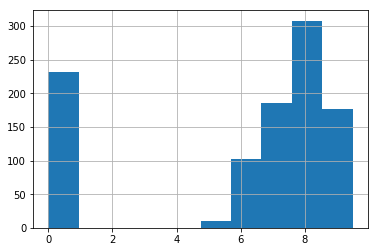

In [6]:
# How Many Ratings are in the dataset  
ratings_df['rating'].hist()

# Save the Venue data .. 
since there API Limits, and analysis might span several days, save current state so can pick up where left off

In [19]:
project.save_data("venue_data.csv", venues_df.to_csv(index=False), overwrite=True)
print (datetime.utcnow()) 

2019-11-03 17:05:34.048292


In [20]:
# Load Venues DataFrame from Project Files
venues_df = pd.read_csv(project.get_file("venue_data.csv"))
print (venues_df.shape)
venues_df.head()



(1037, 10)


,Event Location,Event Location Latitude,Event Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Root Category,Venue Id,Geodesic Distance From Event
0,Middlesex School,42.499832,-71.368431,Minute Man National Park North Bridge,42.468995,-71.350601,Park,Outdoors & Recreation,4df8ea0462847bdf4fedc9da,2.315207
1,Middlesex School,42.499832,-71.368431,Ferns Country Store,42.529475,-71.348768,Sandwich Place,Food,4b93d4a3f964a520e95334e3,2.279200
2,Middlesex School,42.499832,-71.368431,Kimball Farm,42.525479,-71.338571,Ice Cream Shop,Food,5352d0a1498ef37848d305af,2.336431
3,Middlesex School,42.499832,-71.368431,The Concord Minuteman Statue,42.468945,-71.351225,Historic Site,Arts & Entertainment,4f01dcd02c5b66f33e0facd3,2.306039
4,Middlesex School,42.499832,-71.368431,Old North Bridge Visitor Center,42.470904,-71.352697,History Museum,Arts & Entertainment,4c6b0b9e96eaa593049d21df,2.152426


In [21]:
# Spot check a venue
venues_df.loc[venues_df['Venue Id'] == '4abd58d7f964a520da8920e3']

,Event Location,Event Location Latitude,Event Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Root Category,Venue Id,Geodesic Distance From Event
25,Dana Hall School,42.29091,-71.288481,Alta Strada,42.295855,-71.297704,Italian Restaurant,Food,4abd58d7f964a520da8920e3,0.582962



#### Merge Ratings with Venue Data

create `venues_w_rate_df` for venues with ratings.  Preserving the core venues data and core ratings as their own data entities.

In [22]:
# Merge in ratings from stored ratings DataFrame... to clean the across multiple runs
venues_w_rate_df =  pd.merge(venues_df, ratings_df.drop_duplicates(subset=['Venue Id']), on=['Venue Id', 'Venue'], how='left')

In [23]:
print (venues_w_rate_df.shape)
venues_w_rate_df.head()

(1037, 11)


,Event Location,Event Location Latitude,Event Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Root Category,Venue Id,Geodesic Distance From Event,rating
0,Middlesex School,42.499832,-71.368431,Minute Man National Park North Bridge,42.468995,-71.350601,Park,Outdoors & Recreation,4df8ea0462847bdf4fedc9da,2.315207,8.9
1,Middlesex School,42.499832,-71.368431,Ferns Country Store,42.529475,-71.348768,Sandwich Place,Food,4b93d4a3f964a520e95334e3,2.279200,8.3
2,Middlesex School,42.499832,-71.368431,Kimball Farm,42.525479,-71.338571,Ice Cream Shop,Food,5352d0a1498ef37848d305af,2.336431,8.3
3,Middlesex School,42.499832,-71.368431,The Concord Minuteman Statue,42.468945,-71.351225,Historic Site,Arts & Entertainment,4f01dcd02c5b66f33e0facd3,2.306039,7.6
4,Middlesex School,42.499832,-71.368431,Old North Bridge Visitor Center,42.470904,-71.352697,History Museum,Arts & Entertainment,4c6b0b9e96eaa593049d21df,2.152426,7.5


#### Transform venue list 

Transform the venue list so that it is grouped at "per location" basis 



In [24]:
# One Hot Encode the venues based on Top Parent Category ...
# one hot encoding
venues_onehot = pd.get_dummies(venues_w_rate_df[['Venue Root Category']], prefix="", prefix_sep="")

# add Event Location column back to dataframe
venues_onehot['Event Location'] = venues_w_rate_df['Event Location'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Event Location,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Middlesex School,0,0,0,0,1,0,0,0
1,Middlesex School,0,0,1,0,0,0,0,0
2,Middlesex School,0,0,1,0,0,0,0,0
3,Middlesex School,1,0,0,0,0,0,0,0
4,Middlesex School,1,0,0,0,0,0,0,0


In [25]:
venues_onehot.shape

(1037, 9)

In [29]:
# group and find total number of each category
venues_grouped = venues_onehot.groupby('Event Location').sum().reset_index()
print (venues_grouped.shape)
venues_grouped

(23, 9)


,Event Location,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Brewster Academy,1,0,18,3,3,0,6,0
1,Brooks School,0,0,26,2,8,0,9,1
2,Buckingham Browne & Nichols,11,1,56,5,10,0,16,1
3,Dana Hall School,1,1,34,2,25,1,22,1
4,Dexter Southfield School,5,0,49,5,23,1,15,1
5,Governor's Academy,0,0,1,0,7,0,4,0
6,Groton School,0,0,20,2,7,1,10,1
7,Holderness School,2,2,17,2,3,0,8,6
8,Kimball Union Academy,0,0,1,2,3,1,1,0
9,Lawrence Academy,0,0,11,0,8,1,5,1


#### Save the Summarized Venue Data 



In [27]:
## Save Event Lcoation Venue data
## BE CAREFUL, Overwrite = TRUE

project.save_data("event_location_venue_summary.csv", venues_grouped.to_csv(index=False), overwrite=True)

{'file_name': 'event_location_venue_summary.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '34dedc4b-c1c0-4d43-8bdc-89039703e18b'}

#### Load the Data from the CSV 
to pick up where we left off

In [30]:
venues_grouped = pd.read_csv(project.get_file("event_location_venue_summary.csv"))
print (venues_grouped.shape)
venues_grouped.head()

(23, 9)


,Event Location,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Brewster Academy,1,0,18,3,3,0,6,0
1,Brooks School,0,0,26,2,8,0,9,1
2,Buckingham Browne & Nichols,11,1,56,5,10,0,16,1
3,Dana Hall School,1,1,34,2,25,1,22,1
4,Dexter Southfield School,5,0,49,5,23,1,15,1


---  
---  


# Exploratory Data Analysis   

The different aspects of analysis are in no particular order  

### Explore Venue Proximity & Venue Rating around locations  

Below are histograms summarzing   

  1. The Venue's Distance from event location  
  1. The Venue's Rating distribution  
  
**Observations:**  

The further you get from an event location, the more options there tends to be.  This is not surprising since the data set is list of high schools, and most high school campuses do not have many external venues operating on the campus.  I would expect this pattern to be true of many event locations.  

With the limited access to the premium Foursquare API, most venue's do not have any rating data.  At this time, due to the large amount of missing data, no analysis will incorporate rating data.



/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


{'file_name': 'venue_radius_and_ratings.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '2015ff3c-d56e-424d-b270-d8ba7fcc630e'}

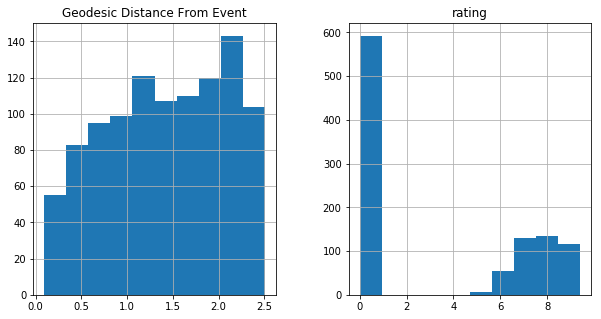

In [70]:
# Plot distribution of Venue Ratings as well as Geodesic Distance from Sporting Event Location
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
venues_df[['rating', 'Geodesic Distance From Event']].hist(ax=ax)
buffer = io.BytesIO()
#fig.show()
plt.savefig(buffer, format='jpg')
buffer.seek(0)
project.save_data('venue_radius_and_ratings.png', buffer, overwrite=True)



### Home location to Away locations:  Travel & High Level Venue Analysis

- Plot how far each away game is (distance)?  
- how long will it take to get there (duration) ? 
- genenerally what's around each school ?


The first analysis is to get a feel for the total population data.  So all schools on the schedule, not just the away games  

**Note**  
Since athlete schedules tend to remain fairly stable in terms of the same opponents every year, but each year they change locations.  So a game location "A" might be home this year will be away next year.  Thus having a general feel all schools is useful.



**Observations**  
The Distance and Duration plots seem like they will cluster relatively smoothly.  In the "all data" plots, no driving or duration bin contains more than 5 schools.  

For the "Nearby Venue" histograms, there is a right skew, which might cause some challenges to clustering.  

In [44]:
school_display_cols = ['home_away', 'date', 'time', 'opponent_school', 'distance_miles', 'duration_minutes', 'duration_str', 'Nearby Venue Count']

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


{'file_name': 'all_event_location_driving_hist_1.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '8985b348-4abf-40b4-899d-92b1b0f3940d'}

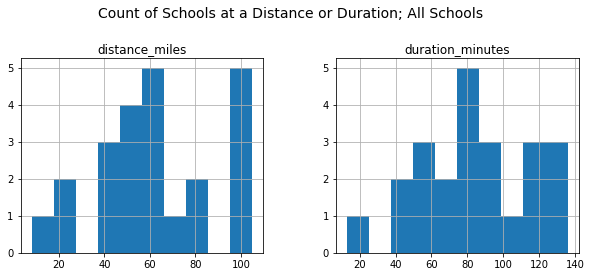

In [66]:
# Driving Analysis to all schools 
# Plot how far each school is, how long will it take to get there, genenerally what's around each school ?

q_col_list = ['distance_miles', 'duration_minutes']
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
games_loc_df[q_col_list].hist(ax=ax)
fig.suptitle('Count of Schools at a Distance or Duration; All Schools', fontsize=14)
plt.subplots_adjust(top=0.80)



buffer = io.BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)
project.save_data('all_event_location_driving_hist_1.png', buffer, overwrite=True)


{'file_name': 'all_event_location_venues_hist_1.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '7d84d7e0-5c3d-4d02-b269-33c9a206c72e'}

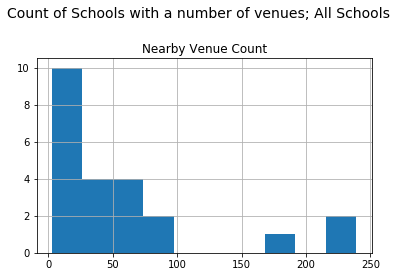

In [67]:
# Venue Analysis to all schools 
# genenerally what's around each school ?

q_col_list = ['Nearby Venue Count']
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
games_loc_df[q_col_list].hist(ax=ax)
fig.suptitle('Count of Schools with a number of venues; All Schools', fontsize=14)
plt.subplots_adjust(top=0.80)


buffer = io.BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)
project.save_data('all_event_location_venues_hist_1.png', buffer, overwrite=True)

Now Repeat this analysis only for the away games

In [38]:
# Create a DataFrame of just the Away Games
away_games_df = games_loc_df.loc[games_loc_df['home_away'] == 'Away'] 


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


{'file_name': 'away_location_driving_hist_1.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '46af667b-c6b5-474e-805e-df3a2d5da7c7'}

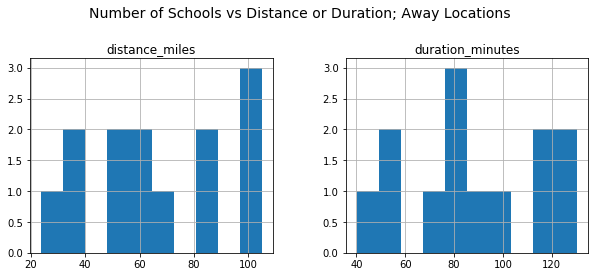

In [63]:
# Distance Analysis
#
# Plot how far each away game is, how long will it take to get there, genenerally what's around each school ?
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
q_col_list = ['distance_miles', 'duration_minutes']
school_display_cols = ['home_away', 'date', 'time', 'opponent_school', 'distance_miles', 'duration_minutes', 'duration_str', 'Nearby Venue Count']
away_games_df[q_col_list].hist(ax=ax)
fig.suptitle('Count of Schools at a Distance or Duration; Away Locations', fontsize=14)
plt.subplots_adjust(top=0.80)

buffer = io.BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)
project.save_data('away_location_driving_hist_1.png', buffer, overwrite=True)


{'file_name': 'away_location_venue_hist_1.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': 'e43c3162-448d-4ca9-9e67-5cfc6b79402c'}

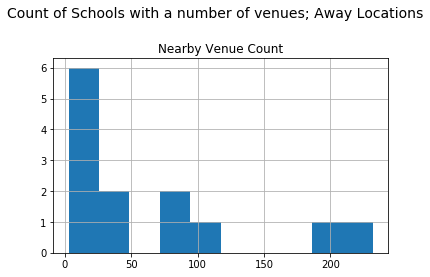

In [64]:
# Venue Analysis
#
# Plot how far each away game is, how long will it take to get there, genenerally what's around each school ?
fig = plt.figure(figsize=(6,4))
fig.suptitle('Away Game Venue')
ax = fig.gca()
q_col_list = ['Nearby Venue Count']
school_display_cols = ['home_away', 'date', 'time', 'opponent_school', 'distance_miles', 'duration_minutes', 'duration_str', 'Nearby Venue Count']
away_games_df[q_col_list].hist(ax=ax)
fig.suptitle('Count of Schools with a number of venues; Away Locations', fontsize=14)
plt.subplots_adjust(top=0.80)

buffer = io.BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)
project.save_data('away_location_venue_hist_1.png', buffer, overwrite=True)


### Numerical Summary of Locations 



In [69]:
# Get numerical summary of All locations
games_loc_df.describe()

,lat,lng,distance_meters,duration_seconds,distance_miles,Nearby Venue Count,duration_minutes
count,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000
mean,42.605610,-71.768867,102065.80000,4955.721739,63.420626,60.826087,82.595362
std,0.573335,0.667594,44821.19187,1926.154144,27.850544,68.647752,32.102569
min,41.491993,-73.245384,12850.50000,778.900000,7.984915,3.000000,12.981667
25%,42.300363,-72.340656,75961.60000,3803.900000,47.200259,16.500000,63.398333
50%,42.593118,-71.574795,98803.80000,5013.800000,61.393717,41.000000,83.563333
75%,42.864149,-71.240521,134308.00000,6427.250000,83.454962,67.000000,107.120833
max,43.761779,-70.902276,168934.60000,8149.100000,104.970892,239.000000,135.818333


In [70]:
# Numerical Summary of Away Games
away_games_df.describe()

,lat,lng,distance_meters,duration_seconds,distance_miles,Nearby Venue Count,duration_minutes
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,42.615806,-71.667284,108031.823077,5283.376923,67.127734,63.615385,88.056282
std,0.628252,0.673951,42210.327794,1770.125290,26.228231,72.881798,29.502088
min,41.491993,-73.245384,38270.700000,2406.800000,23.780265,3.000000,40.113333
25%,42.309817,-71.964796,89181.500000,4490.400000,55.414709,12.000000,74.840000
50%,42.499832,-71.530065,98985.800000,5072.300000,61.506807,41.000000,84.538333
75%,42.978211,-71.273596,134758.800000,7006.000000,83.735076,87.000000,116.766667
max,43.761779,-70.902276,168934.600000,7823.200000,104.970892,232.000000,130.386667


## Exploring Clustering  

One of the goals is to assign labels to location to signal that additional planning is required for this location due to limited number of venues. 



Based on the histograms above lets try simple binning for initial analysis.  

**NOTES**  
  - Since the actual travel to a location is more important than distance, we'll start with binning by `duration_minutes`.  
  - To simplify the analysis, we'll focus on `Food` and `Shop & Services` top-level categories, since the analysis is based on travelling for high-school basketball games.   


First we'll merge the location data with venue data.

In [74]:
# Create a merged DataFrame
# Location + Venue Merged ... and only save Food + Shop & Services 
loc_ven_merged_df = pd.merge(games_loc_df, venues_grouped[['Event Location','Food', 'Shop & Service']], how='left', 
                             left_on='opponent_school', right_on='Event Location')

In [76]:
print(loc_ven_merged_df.shape)
loc_ven_merged_df.head()

(23, 18)


,date,home_away,opponent_school,time,quality,address,state,lat,lng,distance_meters,duration_seconds,distance_miles,duration_str,Nearby Venue Count,duration_minutes,Event Location,Food,Shop & Service
0,"Wednesday, 11/28/2018",Away,Middlesex School,5:00 PM,school,"Middlesex School, 1400, Lowell Road, Concord, ...",Massachusetts,42.499832,-71.368431,62722.6,3051.1,38.973942,0:50,16,50.851667,Middlesex School,4,4
1,"Friday, 11/30/2018",Away,Dana Hall School,5:30 PM,school,"Dana Hall School, 45, Dana Road, Wellesley, No...",Massachusetts,42.290910,-71.288481,89181.5,4490.4,55.414709,1:14,87,74.840000,Dana Hall School,34,22
2,"Saturday, 12/1/2018",Home,Buckingham Browne & Nichols,3:00 PM,school,Buckingham Browne & Nichols School (Middle Sch...,Massachusetts,42.380804,-71.131203,82363.5,4125.8,51.178208,1:08,239,68.763333,Buckingham Browne & Nichols,56,16
3,"Wednesday, 12/5/2018",Away,Holderness School,3:30 PM,school,"Holderness School, Chapel Lane, Holderness, Gr...",New Hampshire,43.761779,-71.674779,167290.4,7161.0,103.949236,1:59,41,119.350000,Holderness School,17,8
4,"Saturday, 12/8/2018",Away,Vermont Academy,4:00 PM,school,"Vermont Academy, Shepard Lane, Saxtons River, ...",Vermont,43.144794,-72.509698,90163.1,5072.3,56.024645,1:24,3,84.538333,Vermont Academy,0,1



#### Bin based on duration  

Let's try binning on duration minutes

After the binning do some simple analysis to check the distrubtion of labels.  3 seems like a good number to start with.

In [78]:
# Try bin'ing

bin_num = 3
group_names = ['Short', 'Medium', 'Long']
loc_ven_merged_df['drive_label'] = pd.cut(loc_ven_merged_df['duration_minutes'], bin_num, labels=group_names, include_lowest=True)

In [91]:
# How many locations for each label 
print (loc_ven_merged_df['drive_label'].value_counts())

# Range captured in each label

for l in ['Short', 'Medium', 'Long']:
    print('\n')

    label_min = loc_ven_merged_df.loc[loc_ven_merged_df['drive_label'] == l][['duration_minutes']].nsmallest(1, 'duration_minutes').min()
    label_max = loc_ven_merged_df.loc[loc_ven_merged_df['drive_label'] == l][['duration_minutes']].nlargest(1, 'duration_minutes').max()
    print('Min {} Duration'.format(l.upper()), label_min)
    print('Max {} Duration'.format(l.upper()), label_max)
    print('{} Label Range'.format(l.upper()), label_max - label_min)



Medium    12
Long       7
Short      4
Name: drive_label, dtype: int64


Min SHORT Duration duration_minutes    12.981667
dtype: float64
Max SHORT Duration duration_minutes    50.851667
dtype: float64
SHORT Label Range duration_minutes    37.87
dtype: float64


Min MEDIUM Duration duration_minutes    55.226667
dtype: float64
Max MEDIUM Duration duration_minutes    88.476667
dtype: float64
MEDIUM Label Range duration_minutes    33.25
dtype: float64


Min LONG Duration duration_minutes    99.045
dtype: float64
Max LONG Duration duration_minutes    135.818333
dtype: float64
LONG Label Range duration_minutes    36.773333
dtype: float64


#### Duration Binning Observations  
The duration binning results look good.  Each label's range roughly 35 minutes, most of the data is `Medium` which reflects reality, and would help.  This short label for duration will convey useful information. 

<br/>  
####  Binning  based on Food Options  

Lets try binning based on food options.  Starting with 3.

In [94]:
bin_num = 3
group_names = ['A Few', 'Some', 'Lots']
loc_ven_merged_df['food_options'] = pd.cut(loc_ven_merged_df['Food'], bin_num, labels=group_names, include_lowest=True)

# How many locations for each label 
print (loc_ven_merged_df['food_options'].value_counts())

# Range captured in each label

for l in group_names:
    print('\n')

    label_min = loc_ven_merged_df.loc[loc_ven_merged_df['food_options'] == l][['Food']].nsmallest(1, 'Food').min()
    label_max = loc_ven_merged_df.loc[loc_ven_merged_df['food_options'] == l][['Food']].nlargest(1, 'Food').max()
    print('Min {} Duration'.format(l.upper()), label_min)
    print('Max {} Duration'.format(l.upper()), label_max)
    print('{} Label Range'.format(l.upper()), label_max - label_min)


A Few    12
Some      7
Lots      4
Name: food_options, dtype: int64


Min A FEW Duration Food    0
dtype: int64
Max A FEW Duration Food    18
dtype: int64
A FEW Label Range Food    18
dtype: int64


Min SOME Duration Food    20
dtype: int64
Max SOME Duration Food    34
dtype: int64
SOME Label Range Food    14
dtype: int64


Min LOTS Duration Food    49
dtype: int64
Max LOTS Duration Food    56
dtype: int64
LOTS Label Range Food    7
dtype: int64


#### Observations  for 3 Bins

The right hand skewness of the data has made the label representing the fewest options ('A Few') very large (over 50% of the data), and the upper bound location in this label has 18 venues.    My intuitions says planning a trip for location with 0 food options is not the same thing as planning a trip to a location with 18 food option.  It is an order of magnitude difference (1 vs 10).  

<br/>  
**Repeating the analysis with 4 buckets (bins)** 


In [95]:
bin_num = 4
group_names = ['Slim Pickins', 'A Few', 'Some', 'Lots']
loc_ven_merged_df['food_options'] = pd.cut(loc_ven_merged_df['Food'], bin_num, labels=group_names, include_lowest=True)

# How many locations for each label 
print (loc_ven_merged_df['food_options'].value_counts())

# Range captured in each label

for l in group_names:
    print('\n')

    label_min = loc_ven_merged_df.loc[loc_ven_merged_df['food_options'] == l][['Food']].nsmallest(1, 'Food').min()
    label_max = loc_ven_merged_df.loc[loc_ven_merged_df['food_options'] == l][['Food']].nlargest(1, 'Food').max()
    print('Min {} Duration'.format(l.upper()), label_min)
    print('Max {} Duration'.format(l.upper()), label_max)
    print('{} Label Range'.format(l.upper()), label_max - label_min)


Slim Pickins    10
A Few            5
Lots             4
Some             4
Name: food_options, dtype: int64


Min SLIM PICKINS Duration Food    0
dtype: int64
Max SLIM PICKINS Duration Food    12
dtype: int64
SLIM PICKINS Label Range Food    12
dtype: int64


Min A FEW Duration Food    17
dtype: int64
Max A FEW Duration Food    28
dtype: int64
A FEW Label Range Food    11
dtype: int64


Min SOME Duration Food    30
dtype: int64
Max SOME Duration Food    34
dtype: int64
SOME Label Range Food    4
dtype: int64


Min LOTS Duration Food    49
dtype: int64
Max LOTS Duration Food    56
dtype: int64
LOTS Label Range Food    7
dtype: int64


#### Observations for 4 Bins  

Intuitively, these results look much more useful.  The distance between max venue count of `Slim Pickins` and the min venue count of `A Few` is 5.  The smallest label, while still the largest label, is now ~43% of the total data (a drop from 53% of total data for the 3-bin cut)

4 Bins for Food options is good choice.


## Lets Try K-Means  

The above binning model solely focused on `Food` options.  Lets try K-Means clustering on all available features 

Using the just the venue summarization data.

First step is to find a good `K`. 

In [98]:
from sklearn.cluster import KMeans

list_k = range(1, 8)
_grouped_clustering = venues_grouped.drop('Event Location', axis=1)

sse = []
for k in list_k:
    print('Running KMeans for k=', k)
    km = KMeans(n_clusters=k)
    km.fit(_grouped_clustering)
    sse.append(km.inertia_)


Running KMeans for k= 1
Running KMeans for k= 2
Running KMeans for k= 3
Running KMeans for k= 4
Running KMeans for k= 5
Running KMeans for k= 6
Running KMeans for k= 7


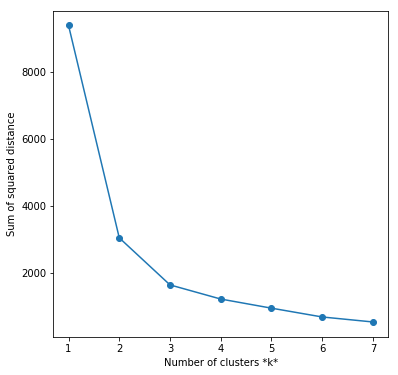

In [99]:
# Plot sse against k
plot_k = list(range(1,8))
plt.figure(figsize=(6, 6))
plt.plot(plot_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Based on the **elbow method** for cluser size, it seems 3 is suggested answer.  

Lets Run KMeans, for `k=3`, and compare those labels to binning with 4 buckets.  

And for comparison to binning, lets also run `k=4`

In [273]:
# use K = 3
k_clusters = 3
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(_grouped_clustering)

# check cluster labels generated for each row in the dataframe
k3_labels = kmeans.labels_ 
k3_centers = kmeans.cluster_centers_

In [271]:
# Lets also use K = 4
k_clusters = 4
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(_grouped_clustering)

# check cluster labels generated for each row in the dataframe
k4_labels = kmeans.labels_ 
k4_centers = kmeans.cluster_centers_

In [114]:
# Lets add the labels back to 
venues_grouped.insert(0,'K3 Labels' , k3_labels)
venues_grouped.insert(0,'K4 Labels' , k4_labels)

print(venues_grouped['K3 Labels'].value_counts())
print(venues_grouped['K4 Labels'].value_counts())

1    12
0     7
2     4
Name: K3 Labels, dtype: int64
1    8
0    6
3    5
2    4
Name: K4 Labels, dtype: int64


In [133]:
venues_grouped.groupby(['K3 Labels']).agg({'Food': ['sum', 'mean', 'count', 'min', 'max']})

Food                         
           sum       mean count min max
K3 Labels                              
A Few       91   7.583333    12   0  18
Lots       210  52.500000     4  49  56
Some       200  28.571429     7  20  34

**Observation for K-MEans(K=3)**  

K-Means with K=3, has the same issue as binning with 3 buckets.  The smallest bucket contains too much data to be practically useful

In [132]:
venues_grouped.groupby(['K4 Labels']).agg({'Food': ['sum', 'mean', 'count', 'min', 'max']})

Food                      
              sum    mean count min max
K4 Labels                              
A Few          78  15.600     5  11  20
Lots          210  52.500     4  49  56
Slim Pickins   33   4.125     8   0   9
Some          180  30.000     6  26  34

**Observation for K-Means(K=4)**  

The clusters are similarly sized (good thing)
The cluster for locations with least number of venues are all in same order of magnitude (i.e. < 10) ...(good thing) 

Ranges are 9, 7, 9, 12 ... so clusters are dense (good thing) 



---  
---  

## Model Selection

Do a quick model evaluation (since it is not easy to pass in the binning model to classic model scoring, use a custom methodology)

  - Weight Average, determined by the range of values per location in a cluster * items in that cluster.  
    For example, if location A, with 16 nearby venues is in the same cluster as Location B, with 22 nearby venues, the range is 6. (i.e. 22-16 = 6).  If there 7 items in the cluster, then the "weight" of that cluster is 7 * 6 = 42  
    
    
  - The difference between the minimum cluster size and maximum cluster size.  To measure the 'balance' the model has in assigning labels


In [155]:
# Used a weighted average of size of cluster * items in cluster)
print ('kmeans(k=4)', (9 * 5 + 7*4 + 9*8 + 12*6)/4)
print ('kmeans(k=3)', (18 * 12 + 7*4 +  14*7)/3)
print ('Binning(bins=3)', (12*18 + 7*14 + 7*4)/3)
print ('Binning(bins=4)', (10*12 + 5*11 + 4*4 + 4*7)/4)

# Check Max - Min bucket delta, for items in each cluster
print ('kmeans(k=4)', 8 - 4)
print ('kmeans(k=3)', 12 - 4)
print ('Binning(bins=3)', 12 - 4)
print ('Binning(bins=4)', 10 - 4)



kmeans(k=4) 54.25
kmeans(k=3) 114.0
Binning(bins=3) 114.0
Binning(bins=4) 54.75
kmeans(k=4) 4
kmeans(k=3) 8
Binning(bins=3) 8
Binning(bins=4) 6


####  KMeans(K=4) is best model

KMeans produced the smallest average cluster weight, as well as the most consistent cluster sizes.

In [134]:
# Use the grouping analysis above, to match KMeans assigned groupings to the original labels from binning
# Then after udpate is done, re-run the groupby statemetns to see a more human readable version
# Lets change labels to match binning
venues_grouped['K3 Labels'].replace({0: 'Some', 1: 'A Few', 2:'Lots' }, inplace=True)
venues_grouped['K4 Labels'].replace({0: 'Some', 1: 'Slim Pickins', 2:'Lots', 3:'A Few'  }, inplace=True)

#### Lets compare the multiple models by looking at actual data

Binning & Kmeans

In [176]:
multi_model_df = pd.merge(loc_ven_merged_df[['opponent_school', 'home_away', 'distance_miles', 'duration_minutes', 'Food', 'Nearby Venue Count', 'drive_label', 'food_options']],
                          venues_grouped[['Event Location', 'K3 Labels', 'K4 Labels']], left_on='opponent_school', right_on='Event Location')
multi_model_df.drop(['Event Location'], axis=1, inplace=True)
multi_model_df.rename({'food_options': 'Bin Labels'}, axis=1, inplace=True)

In [177]:
print(multi_model_df.shape)
multi_model_df

(23, 10)


,opponent_school,home_away,distance_miles,duration_minutes,Food,Nearby Venue Count,drive_label,Bin Labels,K3 Labels,K4 Labels
0,Middlesex School,Away,38.973942,50.851667,4,16,Short,Slim Pickins,A Few,Slim Pickins
1,Dana Hall School,Away,55.414709,74.840000,34,87,Medium,Some,Some,Some
2,Buckingham Browne & Nichols,Home,51.178208,68.763333,56,239,Medium,Lots,Lots,Lots
3,Holderness School,Away,103.949236,119.350000,17,41,Long,A Few,A Few,A Few
4,Vermont Academy,Away,56.024645,84.538333,0,3,Medium,Slim Pickins,A Few,Slim Pickins
5,Miss Porter's school,Home,102.530959,115.196667,30,62,Long,Some,Some,Some
6,Phillips Exeter Academy,Away,83.735076,99.045000,31,72,Long,Some,Some,Some
7,Williston Northampton School,Home,74.717195,88.476667,28,60,Medium,A Few,Some,Some
8,Winchendon School,Home,7.984915,12.981667,12,20,Short,Slim Pickins,A Few,A Few
9,Pomfret School,Away,61.506807,77.778333,5,12,Medium,Slim Pickins,A Few,Slim Pickins


**Observations**  

Comparing Binning(buckets=4) to Kmeans(k=4):  

2 schools left `Slim Pickins` category in Binning model to `A Few` in KMeans model
2 schools left `A Few` category in Binning model to `Some` in KMeans model.

Below is a snapshot of one such school.

In [156]:
#  Lawrence Academy is one of the schools that moved from `Slim Pickins` to `A Few` , Looking at data to see if that "Makes Sense"

venues_w_rate_df.loc[(venues_w_rate_df['Event Location'] == 'Lawrence Academy') & (venues_w_rate_df['Venue Root Category'] == 'Food')]

,Event Location,Event Location Latitude,Event Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Root Category,Venue Id,Geodesic Distance From Event,rating
720,Lawrence Academy,42.604433,-71.562844,Gibbet Hill Grill,42.606217,-71.563914,American Restaurant,Food,4ad282b3f964a52001e220e3,0.134693,0.0
721,Lawrence Academy,42.604433,-71.562844,Filho's Cucina,42.610445,-71.574478,Italian Restaurant,Food,4b9132bff964a52079a933e3,0.723957,0.0
722,Lawrence Academy,42.604433,-71.562844,Salt & Light Cafe Bistro,42.607527,-71.570545,Café,Food,569ef89d498efee6a1359878,0.446994,0.0
726,Lawrence Academy,42.604433,-71.562844,Blackbird Cafe,42.619378,-71.585972,Café,Food,4d1907fb7c5b8eec72acbcc6,1.566735,0.0
727,Lawrence Academy,42.604433,-71.562844,Johnson's Drive-In,42.596187,-71.556070,American Restaurant,Food,4c461673dd35be9a9acfdcd8,0.665770,0.0
731,Lawrence Academy,42.604433,-71.562844,Bruno's Pizza,42.608959,-71.572354,Pizza Place,Food,4c02e465f423a593d67dcf16,0.576827,0.0
732,Lawrence Academy,42.604433,-71.562844,Dunkin',42.606435,-71.569390,Donut Shop,Food,4c6ac1892c29d13a6b810e41,0.361296,0.0
733,Lawrence Academy,42.604433,-71.562844,Dunkin',42.614150,-71.577792,Donut Shop,Food,4bf03907c8d920a180979430,1.015270,0.0
735,Lawrence Academy,42.604433,-71.562844,Scudders @GrotonSchool,42.592237,-71.584551,American Restaurant,Food,4e728fd78877982db9c786e7,1.390708,0.0
736,Lawrence Academy,42.604433,-71.562844,Herb Lyceum,42.619520,-71.582842,New American Restaurant,Food,4bca50730687ef3b48d8dbcc,1.457463,0.0


In [178]:
# Lets Save the multi-model DataFrame

project.save_data("multi_model_data.csv", multi_model_df.to_csv(index=False), overwrite=True)

{'file_name': 'multi_model_data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '78085490-4b4c-4d26-9c77-38d58a42d098'}

---  
---  


# Reporting & Presentation  Support 


This section is miscellaneous data "slicing & dicing", as well as additional visualizations to add the final presentation to coaches to make for a more compelling story.



In [181]:
multi_model_df['food_options'] = multi_model_df['K4 Labels']

{'file_name': 'table_away_games.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': 'fb34b787-53bf-4a98-b708-843b1d1af018'}

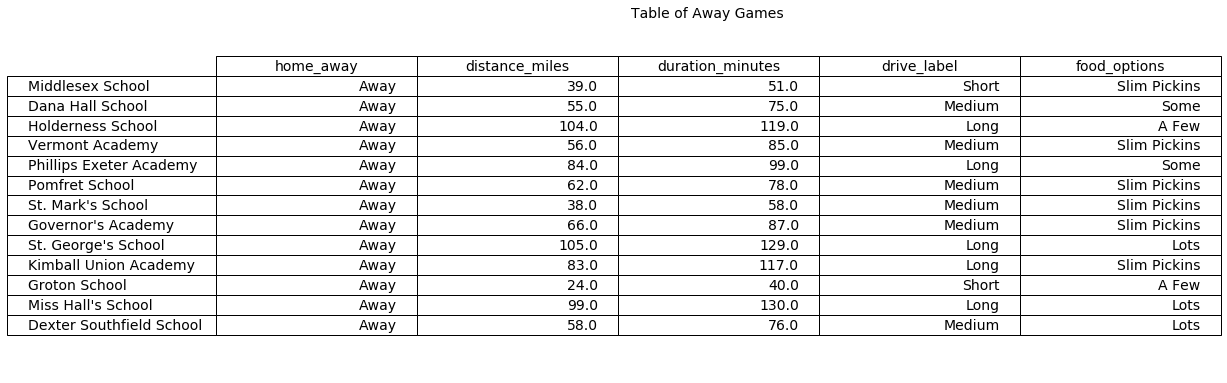

In [215]:
from pandas.plotting import table

table_df = multi_model_df.loc[multi_model_df['home_away']=='Away'][['opponent_school', 'home_away', 'distance_miles', 'duration_minutes', 'drive_label', 'food_options']]
table_df.set_index('opponent_school', inplace=True)

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111, frame_on=False )
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

tbl = table(ax, np.round(table_df), loc='center' )
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(1.5, 1.5)

fig.suptitle('Table of Away Games', fontsize=14)
plt.subplots_adjust(top=0.96)

buffer = io.BytesIO()
plt.savefig(buffer, format='png', bbox_inches='tight')
buffer.seek(0)
project.save_data('table_away_games.png', buffer, overwrite=True)


In [163]:
venues_grouped['Food'].describe()

count    23.000000
mean     21.782609
std      17.946781
min       0.000000
25%       7.000000
50%      18.000000
75%      31.000000
max      56.000000
Name: Food, dtype: float64

In [277]:
venues_grouped.head()

,K4 Labels,K3 Labels,Event Location,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,A Few,A Few,Brewster Academy,1,0,18,3,3,0,6,0
1,Some,Some,Brooks School,0,0,26,2,8,0,9,1
2,Lots,Lots,Buckingham Browne & Nichols,11,1,56,5,10,0,16,1
3,Some,Some,Dana Hall School,1,1,34,2,25,1,22,1
4,Lots,Lots,Dexter Southfield School,5,0,49,5,23,1,15,1


#### Just Play with the data  little bit ...

Not yet for inclusion in the final report or presentation, just randomly play with the data 
see if anything interesting pops out...


In [61]:
games_loc_df.loc[games_loc_df['distance_miles'] < 25]

,Unnamed: 0,date,home_away,opponent_school,time,quality,address,state,lat,lng,distance_meters,duration_seconds,distance_miles,duration_str,Nearby Venue Count
8,8,"Wednesday, 1/16/2019",Home,Winchendon School,3:00 PM,wood,"Winchendon School, Hall Road, Winchendon, Worc...",Massachusetts,42.669447,-72.031826,12850.5,778.9,7.984915,0:12,22
18,18,"Friday, 2/15/2019",Home,Lawrence Academy,6:00 PM,school,"Lawrence Academy, Lowell Road, Groton, Middles...",Massachusetts,42.604433,-71.562844,36846.5,2315.1,22.895310,0:38,25
19,19,"Saturday, 2/16/2019",Away,Groton School,6:00 PM,school,"Groton School, Shirley Road, Groton, Middlesex...",Massachusetts,42.593118,-71.586525,38270.7,2406.8,23.780265,0:40,37


In [83]:
long_trip_duration = 75  # Define 75 minutes as a "Long Trip", since duration is only one-way.  This is a 2hr 30 minute total driving time  
games_loc_df.loc[(games_loc_df['duration_minutes'] > long_trip_duration) & (games_loc_df['home_away'] == 'Away')][school_display_cols]

,home_away,date,time,opponent_school,distance_miles,duration_minutes,duration_str,Nearby Venue Count
3,Away,"Wednesday, 12/5/2018",3:30 PM,Holderness School,103.949236,119.350000,1:59,43
4,Away,"Saturday, 12/8/2018",4:00 PM,Vermont Academy,56.024645,84.538333,1:24,3
6,Away,"Wednesday, 1/9/2019",3:30 PM,Phillips Exeter Academy,83.735076,99.045000,1:39,67
9,Away,"Saturday, 1/19/2019",2:00 PM,Pomfret School,61.506807,77.778333,1:17,12
11,Away,"Friday, 1/25/2019",6:30 PM,Governor's Academy,66.162732,87.046667,1:27,11
14,Away,"Friday, 2/1/2019",6:00 PM,St. George's School,104.970892,129.490000,2:09,192
16,Away,"Saturday, 2/9/2019",4:30 PM,Kimball Union Academy,83.174848,116.766667,1:56,10
20,Away,"Wednesday, 2/20/2019",4:00 PM,Miss Hall's School,99.308596,130.386667,2:10,93
21,Away,"Friday, 2/22/2019",6:00 PM,Dexter Southfield School,57.542839,76.491667,1:16,234


{'file_name': 'three_closest_games.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '6f610cb3-bb69-4778-af70-1447647021e4'}

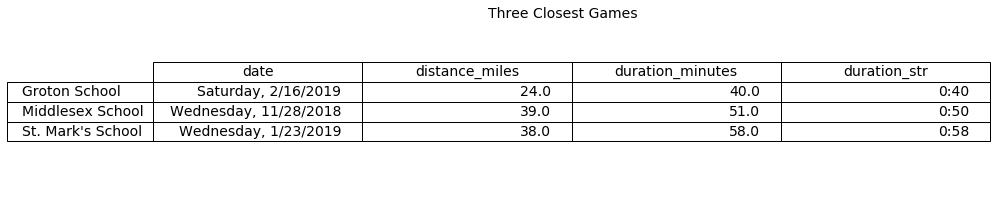

In [263]:
# 3 Closest Trips
_cols = ['opponent_school', 'date', 'distance_miles', 'duration_minutes', 'duration_str']
table_df = games_loc_df.loc[games_loc_df['home_away'] == 'Away'][_cols].nsmallest(3, 'duration_minutes')
table_df.set_index('opponent_school', inplace=True)

fig = plt.figure(figsize=(10,3))
ax = plt.subplot(111, frame_on=False )
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

tbl = table(ax, np.round(table_df), loc='center' )
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(1.5, 1.5)

fig.suptitle('Three Closest Games', fontsize=14)
plt.subplots_adjust(top=0.96)

buffer = io.BytesIO()
plt.savefig(buffer, format='png', bbox_inches='tight')
buffer.seek(0)
project.save_data('three_closest_games.png', buffer, overwrite=True)




{'file_name': 'three_farthest_games.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': 'ade3633c-fecc-4f01-aa07-f183fd132066'}

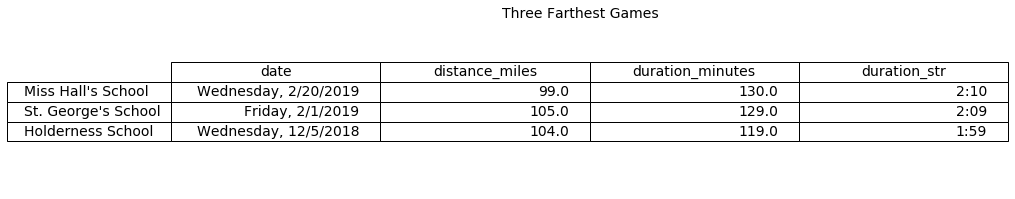

In [266]:
# 3 Furthest Trips

_cols = ['opponent_school', 'date', 'distance_miles', 'duration_minutes', 'duration_str']
table_df = games_loc_df.loc[games_loc_df['home_away'] == 'Away'][_cols].nlargest(3, 'duration_minutes')

table_df.set_index('opponent_school', inplace=True)

fig = plt.figure(figsize=(10,3))
ax = plt.subplot(111, frame_on=False )
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

tbl = table(ax, np.round(table_df), loc='center' )
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(1.5, 1.5)

fig.suptitle('Three Farthest Games', fontsize=14)
plt.subplots_adjust(top=0.96)

buffer = io.BytesIO()
plt.savefig(buffer, format='png', bbox_inches='tight')
buffer.seek(0)
project.save_data('three_farthest_games.png', buffer, overwrite=True)


In [257]:
# Find the 3 closest Food Venues for each away game 
rpt_df = venues_w_rate_df.loc[venues_w_rate_df['Venue Root Category'] == 'Food'].rename({'Geodesic Distance From Event': 'crow_distance'}, axis=1)
#rpt_df = rpt_df.loc(rpt_df['Venue Root Category'] == 'Food']
#rpt_df.set_index('Event Location')
_cols = ['Venue', 'Venue Category', 'crow_distance']
for _s in away_games_df['opponent_school']:
    print (_s)
    print (np.round(rpt_df.loc[rpt_df['Event Location'] == _s][_cols], 2).nsmallest(3, 'crow_distance').to_string(index=False))
    print ('\n\n')


Middlesex School
               Venue     Venue Category  crow_distance
 Ferns Country Store     Sandwich Place           2.28
        Kimball Farm     Ice Cream Shop           2.34
             Monsoon  Indian Restaurant           2.46



Dana Hall School
              Venue      Venue Category  crow_distance
       Truly Yogurt  Frozen Yogurt Shop           0.40
 Amarin of Thailand     Thai Restaurant           0.42
     Tutto Italiano  Italian Restaurant           0.44



Holderness School
                       Venue   Venue Category  crow_distance
 Annie's Overflow Restaurant   Breakfast Spot           0.47
                  Thai Smile  Thai Restaurant           0.64
         Rise and Shine Café             Café           0.68



Vermont Academy
Empty DataFrame
Columns: [Venue, Venue Category, crow_distance]
Index: []



Phillips Exeter Academy
                  Venue           Venue Category  crow_distance
    Blue Moon Evolution  New American Restaurant           0.23
 Seadog Br

Index(['date', 'home_away', 'opponent_school', 'time', 'quality', 'address',
       'state', 'lat', 'lng', 'distance_meters', 'duration_seconds',
       'distance_miles', 'duration_str', 'Nearby Venue Count',
       'duration_minutes'],
      dtype='object')

In [215]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(test_df['sub_total'].to_numpy().reshape(-1, 1)))

MinMaxScaler(copy=True, feature_range=(0, 1))


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [220]:
test_df['location_score'] = scaler.transform(test_df['sub_total'].to_numpy().reshape(-1, 1))


In [222]:
test_df.nsmallest(3, 'location_score')

,date,home_away,opponent_school,time,quality,address,state,lat,lng,distance_meters,...,duration_minutes,dur-bin,Loc-opts,Event Location,Food,Shop & Service,drive_label,food_options,sub_total,location_score
4,"Saturday, 12/8/2018",Away,Vermont Academy,4:00 PM,school,"Vermont Academy, Shepard Lane, Saxtons River, ...",Vermont,43.144794,-72.509698,90163.1,...,84.538333,Medium,Slim Pickins,Vermont Academy,0,1,Medium,Slim Pickins,1,0.000000
16,"Saturday, 2/9/2019",Away,Kimball Union Academy,4:30 PM,school,"Kimball Union Academy, Main Street, Plainfield...",New Hampshire,43.546183,-72.258146,133857.2,...,116.766667,Long,Slim Pickins,Kimball Union Academy,1,1,Long,Slim Pickins,2,0.014085
11,"Friday, 1/25/2019",Away,Governor's Academy,6:30 PM,school,"The Governor's Academy, 1, Middle Road, Newbur...",Massachusetts,42.750087,-70.902276,106478.8,...,87.046667,Medium,Slim Pickins,Governor's Academy,1,4,Medium,Slim Pickins,5,0.056338


In [223]:
test_df.nlargest(3, 'location_score')

,date,home_away,opponent_school,time,quality,address,state,lat,lng,distance_meters,...,duration_minutes,dur-bin,Loc-opts,Event Location,Food,Shop & Service,drive_label,food_options,sub_total,location_score
2,"Saturday, 12/1/2018",Home,Buckingham Browne & Nichols,3:00 PM,school,Buckingham Browne & Nichols School (Middle Sch...,Massachusetts,42.380804,-71.131203,82363.5,...,68.763333,Medium,Lots,Buckingham Browne & Nichols,56,16,Medium,Lots,72,1.000000
20,"Wednesday, 2/20/2019",Away,Miss Hall's School,4:00 PM,school,"Miss Hall's School, Pomeroy Avenue, Pittsfield...",Massachusetts,42.427160,-73.245384,159822.0,...,130.386667,Long,A Few,Miss Hall's School,50,20,Long,Lots,70,0.971831
21,"Friday, 2/22/2019",Away,Dexter Southfield School,6:00 PM,Postal,"02445, Brookline, Massachusetts",Massachusetts,42.325383,-71.131117,92606.4,...,76.491667,Medium,Lots,Dexter Southfield School,49,15,Medium,Lots,64,0.887324


In [204]:
col_list = school_display_cols + ['food_options', 'drive_label', 'Food']
test_df.loc[test_df['drive_label'] == 'Medium'][col_list]

,home_away,date,time,opponent_school,distance_miles,duration_minutes,duration_str,Nearby Venue Count,food_options,drive_label,Food
1,Away,"Friday, 11/30/2018",5:30 PM,Dana Hall School,55.414709,74.840000,1:14,87,Some,Medium,34
2,Home,"Saturday, 12/1/2018",3:00 PM,Buckingham Browne & Nichols,51.178208,68.763333,1:08,239,Lots,Medium,56
4,Away,"Saturday, 12/8/2018",4:00 PM,Vermont Academy,56.024645,84.538333,1:24,3,Slim Pickins,Medium,0
7,Home,"Saturday, 1/12/2019",1:00 PM,Williston Northampton School,74.717195,88.476667,1:28,60,A Few,Medium,28
9,Away,"Saturday, 1/19/2019",2:00 PM,Pomfret School,61.506807,77.778333,1:17,12,Slim Pickins,Medium,5
10,Away,"Wednesday, 1/23/2019",5:00 PM,St. Mark's School,38.115954,58.033333,0:58,17,Slim Pickins,Medium,9
11,Away,"Friday, 1/25/2019",6:30 PM,Governor's Academy,66.162732,87.046667,1:27,12,Slim Pickins,Medium,1
12,Home,"Saturday, 1/26/2019",3:00 PM,Brooks School,55.699420,69.601667,1:09,47,A Few,Medium,26
13,Home,"Wednesday, 1/30/2019",4:30 PM,Wilbraham & Monson Academy,62.528090,83.563333,1:23,22,Slim Pickins,Medium,9
17,Home,"Wednesday, 2/13/2019",4:15 PM,Northfield Mt. Hermon School,43.222311,55.226667,0:55,10,Slim Pickins,Medium,4


In [205]:
print(test_df.loc[games_loc_df['home_away'] == 'Away']['dur-bin'].value_counts())
print(test_df.loc[games_loc_df['home_away'] == 'Away']['Loc-opts'].value_counts())

Medium    6
Long      5
Short     2
Name: dur-bin, dtype: int64
Slim Pickins    8
A Few           3
Lots            2
Some            0
Name: Loc-opts, dtype: int64


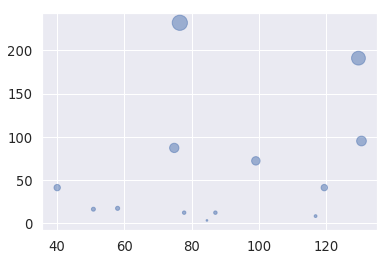

In [163]:
x = test_df.loc[games_loc_df['home_away'] == 'Away']['duration_minutes']
y = test_df.loc[games_loc_df['home_away'] == 'Away']['Nearby Venue Count']
area = y
plt.scatter(x, y, s=area,  alpha=0.5)
plt.show()

In [207]:
merged_test_df.loc[merged_test_df['home_away'] == 'Away'][['opponent_school','dur-bin','Loc-opts', 'Nearby Venue Count', 'Food', 'Shop & Service']]


,opponent_school,dur-bin,Loc-opts,Nearby Venue Count,Food,Shop & Service
0,Middlesex School,Short,Slim Pickins,16,4,4
1,Dana Hall School,Medium,A Few,87,34,22
3,Holderness School,Long,Slim Pickins,41,17,8
4,Vermont Academy,Medium,Slim Pickins,3,0,1
6,Phillips Exeter Academy,Long,A Few,72,31,18
9,Pomfret School,Medium,Slim Pickins,12,5,1
10,St. Mark's School,Medium,Slim Pickins,17,9,4
11,Governor's Academy,Medium,Slim Pickins,12,1,4
14,St. George's School,Long,Lots,191,55,3
16,Kimball Union Academy,Long,Slim Pickins,8,1,1


In [189]:
merged_test_df = pd.merge(test_df, venues_grouped[['Event Location','Food', 'Shop & Service']], how='left', 
         left_on='opponent_school', right_on='Event Location')
merged_test_df.head()


,date,home_away,opponent_school,time,quality,address,state,lat,lng,distance_meters,duration_seconds,distance_miles,duration_str,Nearby Venue Count,duration_minutes,dur-bin,Loc-opts,Event Location,Food,Shop & Service
0,"Wednesday, 11/28/2018",Away,Middlesex School,5:00 PM,school,"Middlesex School, 1400, Lowell Road, Concord, ...",Massachusetts,42.499832,-71.368431,62722.6,3051.1,38.973942,0:50,16,50.851667,Short,Slim Pickins,Middlesex School,4,4
1,"Friday, 11/30/2018",Away,Dana Hall School,5:30 PM,school,"Dana Hall School, 45, Dana Road, Wellesley, No...",Massachusetts,42.290910,-71.288481,89181.5,4490.4,55.414709,1:14,87,74.840000,Medium,A Few,Dana Hall School,34,22
2,"Saturday, 12/1/2018",Home,Buckingham Browne & Nichols,3:00 PM,school,Buckingham Browne & Nichols School (Middle Sch...,Massachusetts,42.380804,-71.131203,82363.5,4125.8,51.178208,1:08,239,68.763333,Medium,Lots,Buckingham Browne & Nichols,56,16
3,"Wednesday, 12/5/2018",Away,Holderness School,3:30 PM,school,"Holderness School, Chapel Lane, Holderness, Gr...",New Hampshire,43.761779,-71.674779,167290.4,7161.0,103.949236,1:59,41,119.350000,Long,Slim Pickins,Holderness School,17,8
4,"Saturday, 12/8/2018",Away,Vermont Academy,4:00 PM,school,"Vermont Academy, Shepard Lane, Saxtons River, ...",Vermont,43.144794,-72.509698,90163.1,5072.3,56.024645,1:24,3,84.538333,Medium,Slim Pickins,Vermont Academy,0,1


In [ ]:
# Come up with a School Location Score ... 
# what % of venues are Food & Shops 


In [88]:

venues_df.loc[(venues_df['Event Location'] == 'Holderness School') & (venues_df['Venue Root Category'] == 'Food' )]


,Event Location,Event Location Latitude,Event Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Root Category,Venue Id,Geodesic Distance From Event,rating
203,Holderness School,43.761779,-71.674779,Biederman's Deli and Pub,43.757824,-71.687622,Sandwich Place,Food,4ba4036af964a520c47738e3,0.698237,8.8
204,Holderness School,43.761779,-71.674779,Burrito Me,43.756996,-71.687864,Burrito Place,Food,4f722ff5e4b07e78e2f98071,0.733296,8.5
207,Holderness School,43.761779,-71.674779,Six Burner Bistro,43.753565,-71.687654,American Restaurant,Food,4be88e7b947820a1470fb5db,0.858289,8.2
208,Holderness School,43.761779,-71.674779,M 'n M Scoops,43.757273,-71.687683,Ice Cream Shop,Food,4fb81878754acd863d3fb4bd,0.716740,8.0
209,Holderness School,43.761779,-71.674779,Rise and Shine Café,43.769122,-71.683850,Café,Food,4c3cf90b17f2ef3b2a4081f4,0.680454,7.9
212,Holderness School,43.761779,-71.674779,Annie's Overflow Restaurant,43.760108,-71.683941,Breakfast Spot,Food,4d29a8d38292236a89f924bb,0.472745,7.6
213,Holderness School,43.761779,-71.674779,Cafe Monte Alto,43.757877,-71.687606,Coffee Shop,Food,4bdaed213904a59397e2479e,0.696072,7.6
214,Holderness School,43.761779,-71.674779,Phat Fish,43.756660,-71.687560,Seafood Restaurant,Food,5869b437424f937f62ac8cb6,0.730686,7.5
215,Holderness School,43.761779,-71.674779,Foster's Boiler Room,43.769060,-71.684031,American Restaurant,Food,4b42a4e2f964a52017d825e3,0.683376,7.5
217,Holderness School,43.761779,-71.674779,Thai Smile,43.759605,-71.687296,Thai Restaurant,Food,4ceaa65c595cb1f7a61ad514,0.644027,7.3


{'file_name': 'venue_school_heatmap.png',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcrs9capstone-donotdelete-pr-afds8o4rva78zh',
 'asset_id': '486fe450-4d19-4452-9b73-0dd1e54210e1'}

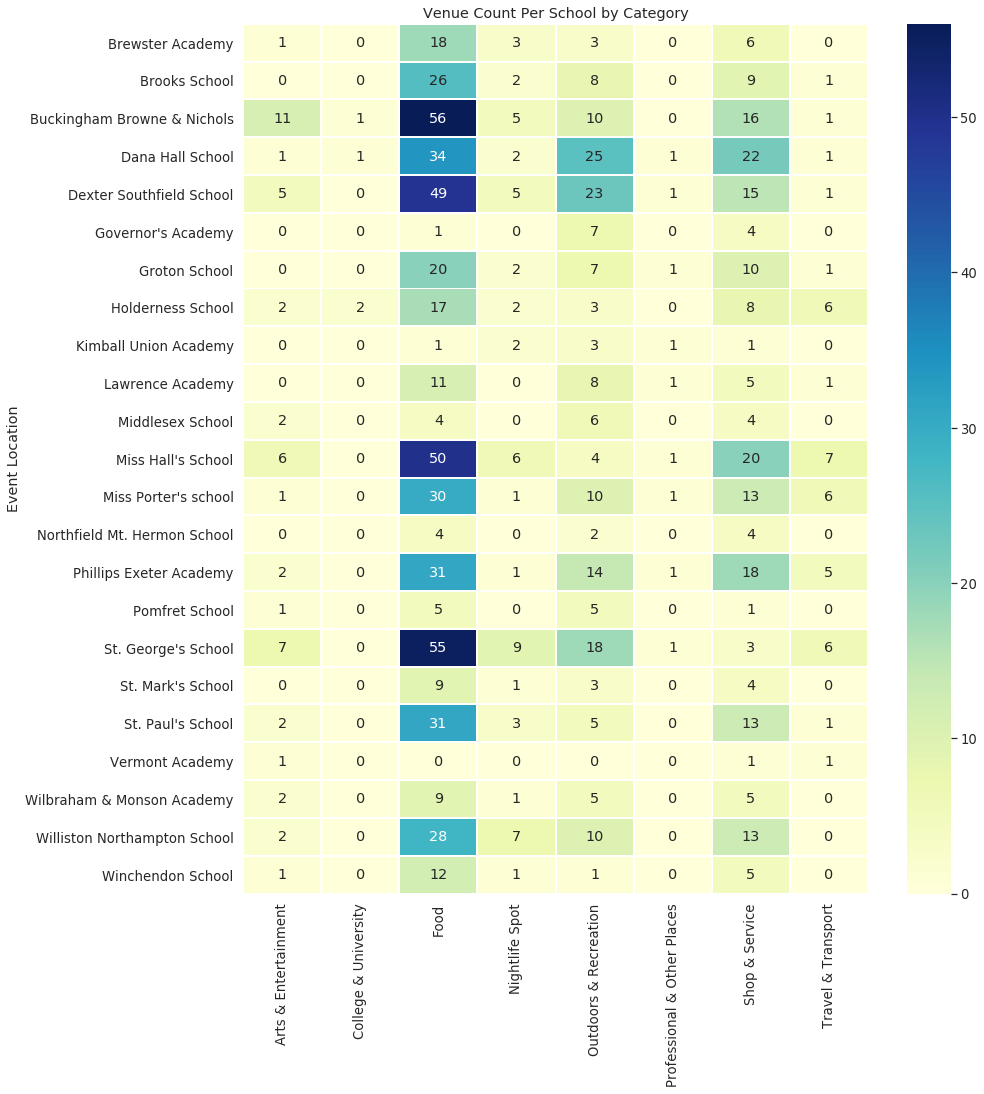

In [86]:
import seaborn as sns
sns.set(font_scale=1.2)
plt.figure(figsize=(14,16))
ax = plt.axes()
sns.heatmap(venues_grouped.set_index('Event Location'), linewidths=1., cmap='YlGnBu', annot=True, fmt="d", ax=ax)
ax.set_title("Venue Count Per School by Category")

buffer = io.BytesIO()
plt.savefig(buffer, format='png', bbox_inches='tight')
buffer.seek(0)
project.save_data('venue_school_heatmap.png', buffer, overwrite=True)


In [178]:
venues_grouped[['Event Location','Food', 'Shop & Service']].head()

,Event Location,Food,Shop & Service
0,Brewster Academy,18,6
1,Brooks School,26,9
2,Buckingham Browne & Nichols,56,16
3,Dana Hall School,34,22
4,Dexter Southfield School,49,15


In [91]:
venues_grouped.head()

,Event Location,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Brewster Academy,1,0,18,3,3,0,6,0
1,Brooks School,0,0,26,2,8,0,9,1
2,Buckingham Browne & Nichols,11,1,56,5,10,0,16,1
3,Dana Hall School,1,1,34,2,25,1,22,1
4,Dexter Southfield School,5,0,49,5,23,1,15,1


---  
---


In [14]:
games_loc_df.columns

Index(['date', 'home_away', 'opponent_school', 'time', 'quality', 'address',
       'state', 'lat', 'lng', 'distance_meters', 'duration_seconds',
       'distance_miles', 'duration_str', 'Nearby Venue Count',
       'duration_minutes'],
      dtype='object')

In [39]:
away_games_df = games_loc_df.loc[games_loc_df['home_away'] == 'Away']

home_base_map = folium.Map(location=[42.63286695, -71.9135057096491], zoom_start=8)
folium.Marker(location=[42.63286695, -71.9135057096491], 
              popup='Cushing Academy',
             icon=folium.Icon(icon='home', color='purple', prefix='fa')).add_to(home_base_map)
# add markers to map
for lat, lng, opponent_school, _date in zip(away_games_df['lat'], away_games_df['lng'], away_games_df['opponent_school'], away_games_df['date']):
    label = '{}; {}'.format( opponent_school, _date)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7, 
        parse_html=False).add_to(home_base_map)  

In [43]:
home_base_map